# 决策树

> 是一种常见的机器学习算法，顾名思义，决策树是基于树的结构来进行决策的，这正好是人类在解决问题的很自然的方式，对于一个问题的解，我们常常会进行一系列判断，最终得到决策。
决策树的构成需要以当前的一个特征作为树的各个节点，那么如何取得各个的特征成为难点。

### 首先介绍ID3算法

ID3算法使用信息增益来取得最好的特征，求信息增益，首先求信息熵
$$
Ent(D) = -\sum{p_k\log{2}{p_k}}
$$
那么，信息增益为
$$
Gain(D,a) = Ent(D)-\sum{\frac{D^v}{D}Ent(D^v)}
$$
其中，a为某一个特征（属性）

In [2]:
import numpy as np
import math

In [16]:
# 计算信息熵
def calculate_entropy(y):
    log2 = math.log2
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

In [18]:
# 定义树的节点
class DecisionNode():
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          
        self.threshold = threshold         
        self.value = value                 
        self.true_branch = true_branch     
        self.false_branch = false_branch

In [19]:
def divide_on_feature(X, feature_i, threshold):
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])

In [53]:
# 超类
class DecisionTree(object):
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  #根节点
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        # 计算值 如果是分类问题就是信息增益，回归问题就基尼指数
        self._impurity_calculation = None
        self._leaf_value_calculation = None #计算叶子
        self.one_dim = None
        self.loss = loss

    def fit(self, X, y, loss=None):
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """
        递归求解树
        """

        largest_impurity = 0
        best_criteria = None
        best_sets = None
        
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # 计算每一个特征的增益值
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                for threshold in unique_values:
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)
                    
                    if len(Xy1) > 0 and len(Xy2) > 0:
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # 计算增益值
                        impurity = self._impurity_calculation(y, y1, y2)

                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],  
                                "lefty": Xy1[:, n_features:],   
                                "rightX": Xy2[:, :n_features],  
                                "righty": Xy2[:, n_features:]   
                                }

        if largest_impurity > self.min_impurity:
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)
        
        # 计算节点的目标值
        leaf_value = self._leaf_value_calculation(y)
        
        
        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """
        预测
        """

        if tree is None:
            tree = self.root

        if tree.value is not None:
            return tree.value

        feature_value = x[tree.feature_i]

        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        return self.predict_value(x, branch)

    def predict(self, X):
        y_pred = []
        for x in X:
            y_pred.append(self.predict_value(x))
        return y_pred

In [91]:
class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # 计算信息增益
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * calculate_entropy(y1) - (1 - p) * calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # 投票决定当前的节点为哪一个类
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

## 分类决策树演示

In [110]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
data = datasets.load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
clf = ClassificationTree()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)

In [111]:
accuracy

0.94999999999999996

### emmmm 看起来还不错

## 那么，什么是决策时回归呢？

> 我们一般使用决策树进行决策，很少用其来进行回归，如果是回归问题就使用基尼指数
$$
Gini = 1- \sum{{p_k}^2}
$$
那么 属性a的基尼指数为
$$
Gini_index(D,a) = \sum{\frac{D^v}{D}Gini(D^v)}
$$

In [116]:
def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance

In [118]:
class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # 使用方差缩减
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

In [125]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [126]:
data = pd.read_csv('TempLinkoping2016.txt', sep="\t")

In [127]:
time = np.atleast_2d(data["time"].as_matrix()).T
temp = np.atleast_2d(data["temp"].as_matrix()).T

X = time
y = temp[:, 0]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [129]:
model = RegressionTree()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [130]:
mse = mean_squared_error(y_test, y_pred)

In [131]:
mse

7.4523636363636365

In [132]:
from matplotlib import pyplot as plt
%matplotlib inline

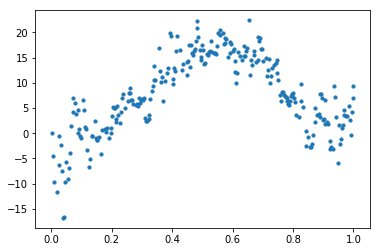

In [134]:
m1 = plt.scatter(X_train, y_train, s=10)

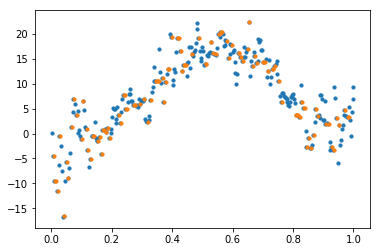

In [136]:
plt.scatter(X_train, y_train, s=10)
plt.scatter(X_test, y_pred, s=10)